In [9]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
from pyMRI.utils import RMSE

In [10]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i:met_i + 1], t2s[met_i:met_i + 1], M_0s[met_i:met_i + 1]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


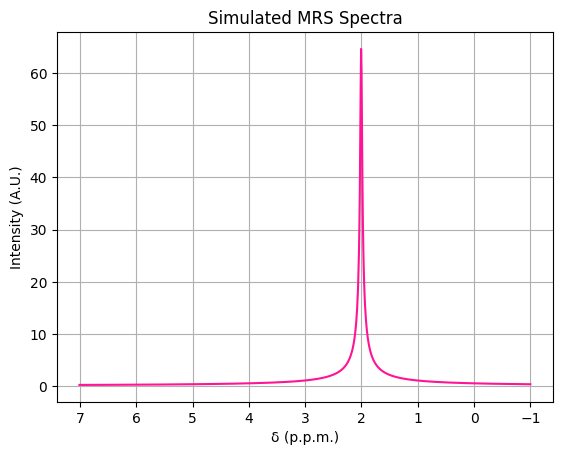

In [11]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [12]:
L = 0.4
L_ = int(L*sig.size)
rcond = 1e-15
zero_filtering=1e-30

In [13]:
noise_threshold = np.arange(1.5, 1.8, 0.03)
# noise_threshold = np.array([1.65])
sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])
print(np.power(10.0, -noise_threshold))

[0.03162278 0.02951209 0.02754229 0.02570396 0.02398833 0.02238721
 0.02089296 0.01949845 0.01819701 0.01698244 0.01584893]


In [14]:
n_avgs = 10
shape = (noise_threshold.size, n_avgs, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
original_c_sigs = np.zeros((n_avgs, 2048), dtype=np.complex128)

In [15]:
SNR = sample_snrs[3]
print(SNR)

1.0


In [16]:
rerun = False
save = False
filename_end = "_" + str(int(SNR))
folder_name = "files/"
subfolder_name = "svd_second_testing/"

Abaixo, o loop foi "consertado" para uniformizar os resultados: antes, ele produzia sinais diferentes com ruídos diferentes para cada `noise_threshold`, agora ele produz apenas um sinal para todos, mas diferente a cada média. 

In [17]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)
sig, t = pymri.population_transverse_decay(t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft_ = sig_fft/np.nanmax(sig_fft)

if rerun == True:
    for j in range(n_avgs):
        c_sig_fft = awgn(sig_fft_, SNR)
        original_c_sigs[j, :] = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

        for i in range(noise_threshold.size):

            print(noise_threshold[i])
            f_sig, z, r = pymri.filter_sig(original_c_sigs[j, :], L, noise_threshold[i], 
                                        return_poles_and_res=True, 
                                        return_full_arrays=True, 
                                        rcond=rcond, 
                                        zero_filtering=zero_filtering)
            
            
            # pymri.plot_chem_shifts(freqs, pymri.fourier_spectrum(f_sig, dt, B0)[1])
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
        print("--" + str(j) + "--")

In [18]:
if rerun == True and save == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)
    np.save(folder_name + subfolder_name + "original_c_sigs" + filename_end, original_c_sigs)

In [19]:
if rerun == False:
    s0s_            = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_           = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_         = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_            = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
    original_c_sigs = np.load(folder_name + subfolder_name + "original_c_sigs" + filename_end + ".npy")


In [20]:
n_possible_freqs = np.zeros((noise_threshold.size, n_avgs))

In [21]:
limit_omega = pymri.max_frequency(dt)
print(limit_omega)

1024.0


In [22]:
filter_omegas = np.abs(pymri.rad_to_hz(omegas_)) <= limit_omega
print(filter_omegas[0, 0].shape, omegas_.shape)

for j in range(n_avgs):
    for i in range(noise_threshold.size):
        n_possible_freqs[i, j] = omegas_[i, j][filter_omegas[i, j]].size

(819,) (11, 10, 819)


In [23]:
avg_n_possible_freqs = np.average(n_possible_freqs, axis = 1)
std_n_possible_freqs = np.std(n_possible_freqs, axis = 1)

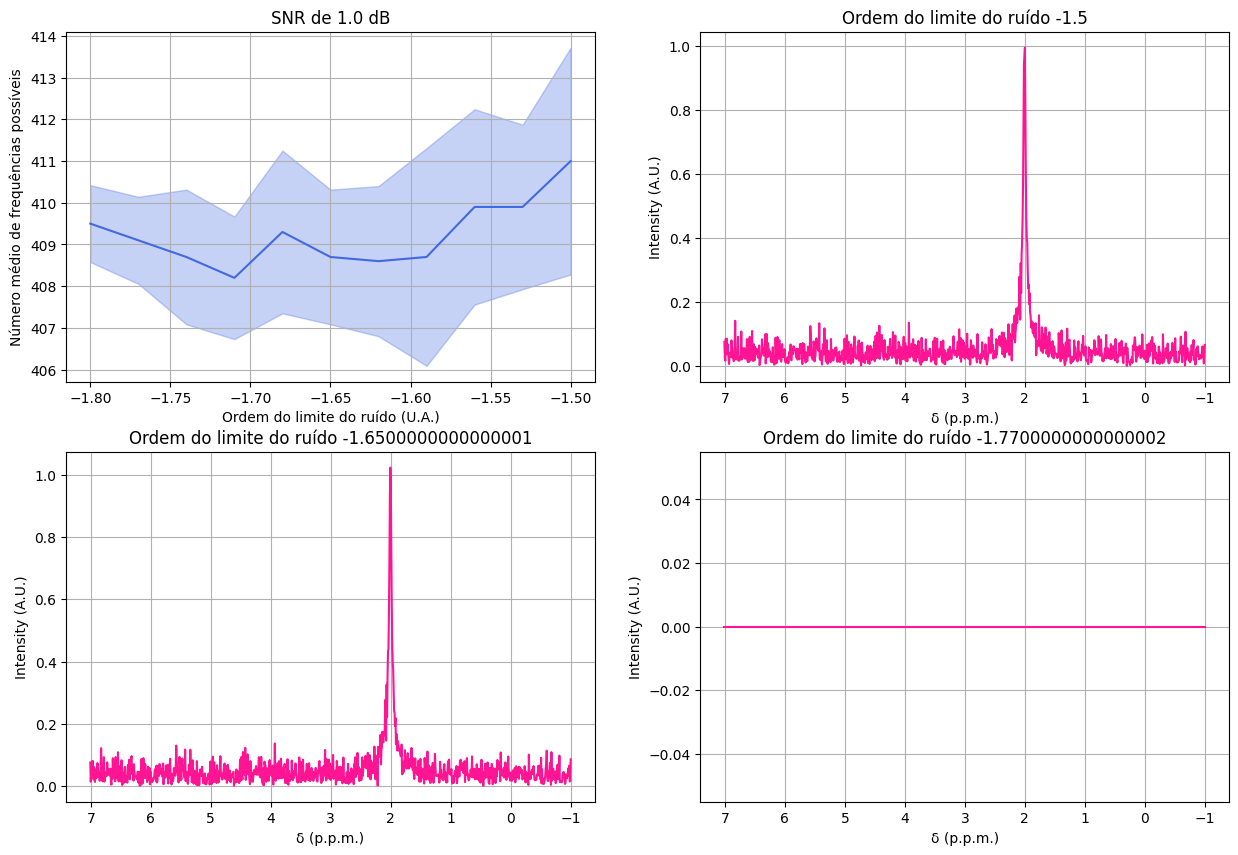

In [24]:
avg = 6 #avg 6 noise_3 9 tem um problema
noise_1 = 0
noise_2 = 5
noise_3 = 9

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(-noise_threshold, avg_n_possible_freqs, c = "royalblue")
plt.fill_between(-noise_threshold, avg_n_possible_freqs - std_n_possible_freqs, avg_n_possible_freqs + std_n_possible_freqs, color = "royalblue", alpha = 0.3)
plt.title(f"SNR de {SNR} dB")
plt.xlabel("Ordem do limite do ruído (U.A.)")
plt.ylabel("Número médio de frequências possíveis")
plt.grid()

plt.subplot(222)
# print(omegas_[noise_1, avg].size)
c_pop = pymri.population(omegas_[noise_1, avg], t2s_[noise_1, avg], s0s_[noise_1, avg], phis_[noise_1, avg])
c_sig, t = pymri.population_transverse_decay(t0, tn, dt, c_pop)
_, c_sig_fft = pymri.fourier_spectrum(c_sig, dt, B0)
pymri.plot_chem_shifts(freqs, c_sig_fft, 
                       title=f"Ordem do limite do ruído {-noise_threshold[noise_1]}")
# plt.ylim(-0.1, 1.1)

plt.subplot(223)
# print(phis_[noise_2, avg])
c_pop = pymri.population(omegas_[noise_2, avg], t2s_[noise_2, avg], s0s_[noise_2, avg], phis_[noise_2, avg])
c_sig, t = pymri.population_transverse_decay(t0, tn, dt, c_pop)
_, c_sig_fft = pymri.fourier_spectrum(c_sig, dt, B0)
pymri.plot_chem_shifts(freqs, c_sig_fft, 
                       title=f"Ordem do limite do ruído {-noise_threshold[noise_2]}")
# plt.ylim(-0.1, 1.1)

plt.subplot(224)
c_pop = pymri.population(omegas_[noise_3, avg], t2s_[noise_3, avg], s0s_[noise_3, avg], phis_[noise_3, avg])
c_sig, t = pymri.population_transverse_decay(t0, tn, dt, c_pop)
_, c_sig_fft = pymri.fourier_spectrum(c_sig, dt, B0)
pymri.plot_chem_shifts(freqs, c_sig_fft, 
                       title=f"Ordem do limite do ruído {-noise_threshold[noise_3]}")
# plt.ylim(-0.1, 1.1)

Aparentemente o número médio de frequências possíveis calculadas não muda significativamente a depender do parâmetro do svd. O número parece ficar por volta da metade da quantidade total de frequências calculadas (L_ = 819).

Comentário importante: foi percebida uma instabilidade significativa no algoritmo com relação ao cálculo dos parâmetros Z e R na função `filter_sig`, especialmente no cálculo do R, que envolve mínimos quadrados: para alguns casos, o R é calculado, para outros ele é calculado muito próximo de zero.

Aparentemente, a matriz Zs pode se tornar ill-conditioned em alguns casos, o que está comprometendo completamente a instabilidade dos mínimos quadrados. Deve-se resolver esse problema antes de prosseguir. RESPOSTA: alterei o valor do rcond para `1e-15` e parece que voltou a ser um pouco mais estável.